# Three-body conservative kernel for two chemical species

In [27]:
# import libraries
import theano
import theano.tensor as T
from theano import function
import numpy as np

### Definitions

Define the position of the atoms relative to the centrla one, and their chemical species, by a matrix of dimension Mx5

In [28]:
# positions of central atoms
r1, r2 = T.dvectors('r1d','r2d') 
# positions of neighbours 
rho1, rho2 = T.dmatrices('rho1','rho2') 
# hyperparameter
sig = T.dscalar('sig') 


In [29]:
# positions of neighbours without chemical species

rho1s = rho1[:, 0:3]
rho2s = rho2[:, 0:3]

alpha_1 = rho1[:, 3].flatten()
alpha_2 = rho2[:, 3].flatten()

alpha_j = rho1[:, 4].flatten()
alpha_m = rho2[:, 4].flatten()

alpha_k = rho1[:, 4].flatten()
alpha_n = rho2[:, 4].flatten()


Calculate the relative distance to the central vector

In [30]:
# first configuration
r1j = T.sqrt(T.sum((rho1s[:, :]-r1[None,:])**2, axis = 1))

# second configuration
r2m = T.sqrt(T.sum((rho2s[:, :]-r2[None,:])**2, axis = 1))


Calculate the distances between the neighbours

In [31]:
# first configuration
rjk = T.sqrt(T.sum((rho1s[None, :, :] - rho1s[:, None, :])**2, axis = 2))

# second configuration
rmn = T.sqrt(T.sum((rho2s[None, :, :] - rho2s[:, None, :])**2, axis = 2))


Calculate the mask given by the chemical species

In [32]:
#def delta_alpha(a1j, a2m):
#    d = (a1j == a2m)
#    dn =  float(d == 'true')
#    return dn

In [33]:
# !!! THIS IS NOT AN EXACT KRONECKER SYMBOL !!!

def delta_alpha2(a1j, a2m):
    d = np.exp(-(a1j - a2m)**2/(2*(1e-5)**2))
    return d

Now let us calculate all the kronecker deltas for all 6 permutations of atoms in the second triplet. These are

$$ P1 + P2 + P3 + P4 + P5 + P6$$

$$ \delta_{1jk,2mn} + \delta_{1jk,2nm} + \delta_{1jk,mn2} + \delta_{1jk,m2n} + \delta_{1jk,n2m} + \delta_{1jk,nm2} $$

$$ \delta_{12}\delta_{jm}\delta_{kn} + \delta_{12}\delta_{jn}\delta_{km} + \delta_{1m}\delta_{jn}\delta_{k2} + \delta_{1m}\delta_{j2}\delta_{kn} + \delta_{1n}\delta_{j2}\delta_{km} + \delta_{1n}\delta_{jm}\delta_{k2} $$

In [60]:
# permutation 1

delta_alphas12 = delta_alpha2(alpha_1[0] , alpha_2[0])
delta_alphasjm = delta_alpha2(alpha_j[:, None] , alpha_m[None, :])
delta_alphaskn = delta_alpha2(alpha_k[:, None] , alpha_n[None, :])
delta_alphas_jmkn = delta_alphasjm[:,None,:,None] * delta_alphaskn[None, :, None, :]

delta_perm1 = delta_alphas12 * delta_alphas_jmkn

# permutation 2

delta_alphas12 = delta_alpha2(alpha_1[0] , alpha_2[0])
delta_alphasjn = delta_alpha2(alpha_j[:, None] , alpha_n[None, :])
delta_alphaskm = delta_alpha2(alpha_k[:, None] , alpha_m[None, :])
delta_alphas_jnkm = delta_alphasjn[:,None,:,None] * delta_alphaskm[None, :, None, :]

delta_perm2 = delta_alphas12 * delta_alphas_jnkm

# permutation 3
delta_alphas1m = delta_alpha2(alpha_1[0, None] , alpha_m[None, :]).flatten()
delta_alphasjn = delta_alpha2(alpha_j[:, None] , alpha_n[None, :])
delta_alphask2 = delta_alpha2(alpha_k[:, None] , alpha_2[None, 0]).flatten()
delta_alphas_k21m = delta_alphask2[:, None] * delta_alphas1m[None, :] 

delta_perm3 = delta_alphas_k21m[:,None,:,None] * delta_alphasjn[None, :, None, :]


# permutation 4
delta_alphas1m = delta_alpha2(alpha_1[0, None] , alpha_m[None, :]).flatten()
delta_alphasj2 = delta_alpha2(alpha_j[:, None] , alpha_2[None, 0]).flatten()
delta_alphaskn = delta_alpha2(alpha_k[:, None] , alpha_n[None, :])
delta_alphas_j21m = delta_alphasj2[:, None] * delta_alphas1m[None, :]

delta_perm4 = delta_alphas_j21m[:,None,:,None] * delta_alphaskn[None, :, None, :]

# permutation 5
delta_alphas1n = delta_alpha2(alpha_1[0, None] , alpha_n[None, :]).flatten()
delta_alphasj2 = delta_alpha2(alpha_j[:, None] , alpha_2[None, 0]).flatten()
delta_alphaskm = delta_alpha2(alpha_k[:, None] , alpha_m[None, :])
delta_alphas_j21n = delta_alphasj2[:, None] * delta_alphas1n[None, :]

delta_perm5 = delta_alphas_j21n[:,None,:,None] * delta_alphaskm[None, :, None, :]

# permutation 6
delta_alphas1n = delta_alpha2(alpha_1[0, None] , alpha_n[None, :]).flatten()
delta_alphasjm = delta_alpha2(alpha_j[:, None] , alpha_m[None, :])
delta_alphask2 = delta_alpha2(alpha_k[:, None] , alpha_2[None, 0]).flatten()
delta_alphas_k21n = delta_alphask2[:, None] * delta_alphas1n[None, :]

delta_perm6 = delta_alphas_k21n[:,None,:,None] * delta_alphasjm[None, :, None, :]

### Kernel

Calculate the kernel on all combinations of radii

In [61]:
# Squared exp of differences
se_1j2m = T.exp(-(r1j[:,None] - r2m[None,:])**2/(2*sig**2))
se_jkmn = T.exp(-(rjk[:,:,None,None] - rmn[None,None,:,:])**2/(2*sig**2))
se_jk2m = T.exp(-(rjk[:,:,None] - r2m[None, None,:])**2/(2*sig**2))
se_1jmn = T.exp(-(r1j[:,None, None] - rmn[None,:,:])**2/(2*sig**2))

Build the kernel

In [62]:
# Kernel not summed (cyclic permutations)
k1n = (se_1j2m[:,None, :, None]*se_1j2m[None, :, None,:]*se_jkmn)
k2n = (se_1jmn[:,None, :, :]*se_jk2m[:, :, None,:]*se_1j2m[None,:,:,None])
k3n = (se_1j2m[:,None, None, :]*se_jk2m[:, :, :,None]*se_1jmn[None,:, :, :])

# final shape is M1 M1 M2 M2

# kernel
ker_jkmn = (k1n+k2n+k3n)*(delta_perm1+delta_perm2+delta_perm3 + delta_perm4 + delta_perm5 + delta_perm6)



PROBLEM

In the way we defined the delta functions, the two configurations H-Ni-Ni and Ni-H-H are not equal (and that's right). However, this won't work well for the "pairwise terms" in the sum since these should actually recognise those as being equal. What possibly should be done at this point is building a mask of ones and se

In [63]:
mask_jk = T.ones_like(rjk) - T.identity_like(rjk)
mask_mn = T.ones_like(rmn) - T.identity_like(rmn)

mask_jkmn = mask_jk[:, :, None, None] * mask_mn[None, None, :, :]

mask_jk.eval({rjk: np.zeros((5, 5))})

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

In [64]:
# energy energy kernel
kerncut = T.sum(ker_jkmn*mask_jkmn)
kfun = function([r1, r2, rho1, rho2, sig], kerncut)


In [65]:
# energy force kernel
G3b_ms = T.grad(kerncut, r1)
G3b_ms_fun = function([r1, r2, rho1, rho2, sig], G3b_ms)


Take Hessian

In [66]:
# force force kernel
gr1 = T.grad(kerncut, r1)

H3b_ms, updates = theano.scan(lambda j, gr1, r2 : T.grad(gr1[j], r2), sequences = T.arange(gr1.shape[0]), non_sequences = [gr1, r2])
H3b_ms_fun = function([r1, r2, rho1, rho2, sig], H3b_ms)

Saving the kernel

In [42]:
from six.moves import cPickle
import sys

sys.setrecursionlimit(3000)
f = open('H3b_ms.save', 'wb')
cPickle.dump(H3b_ms_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('G3b_ms.save', 'wb')
cPickle.dump(G3b_ms_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('S3b_ms.save', 'wb')
cPickle.dump(kfun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()


NameError: name 'H3b_ms_fun' is not defined

### Kernel with cutoff function

In [67]:
theta = T.dscalar('theta')
rc = T.dscalar('rc')

ker_jkmn_withcutoff = (k1n+k2n+k3n)*(delta_perm1+delta_perm2+delta_perm3 + delta_perm4 + delta_perm5 + delta_perm6)*(
    T.exp(-theta/(rc-r1j[:,None,None,None]))* T.exp(-theta/(rc-r1j[None,:,None,None]))* T.exp(-theta/(rc-rjk[:,:,None,None])) * 
    T.exp(-theta/(rc-r2m[None,None,None,:]))* T.exp(-theta/(rc-r2m[None,None,:,None]))* T.exp(-theta/(rc-rmn[None,None,:,:])) *
(0.5*(T.sgn(rc-rjk[:,:,None,None])+1)) * (0.5*(T.sgn(rc-rmn[None,None,:,:])+1)))

k_cutoff = T.sum(ker_jkmn_withcutoff*mask_jkmn)

In [68]:
#pi = T.constant('pi')

ker_jkmn_withcutoff_v2 = (k1n+k2n+k3n)*(delta_perm1+delta_perm2+delta_perm3 + delta_perm4 + delta_perm5 + delta_perm6)*(
    T.exp(-theta/(rc-r1j[:,None,None,None]))* T.exp(-theta/(rc-r1j[None,:,None,None]))* T.exp(-theta/(rc-rjk[:,:,None,None])) * 
    T.exp(-theta/(rc-r2m[None,None,None,:]))* T.exp(-theta/(rc-r2m[None,None,:,None]))* T.exp(-theta/(rc-rmn[None,None,:,:])) )

k_cutoff_v2 = T.sum(ker_jkmn_withcutoff*mask_jkmn)

In [69]:
# energy energy kernel
k_ee_cut_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_cutoff)

# energy force kernel
k_ef_cut = T.grad(k_cutoff, r2)
k_ef_cut_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ef_cut)

# force force kernel
k_ff_cut = T.grad(k_cutoff, r1)
k_ff_cut_der, updates = theano.scan(lambda j, k_ff_cut, r2 : T.grad(k_ff_cut[j], r2), sequences = T.arange(k_ff_cut.shape[0]), non_sequences = [k_ff_cut, r2])
k_ff_cut_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ff_cut_der)

Saving the cutoff kernels

In [70]:
sys.setrecursionlimit(3000)

f = open('3B_ee_ker_cut.save', 'wb')
cPickle.dump(k_ee_cut_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('3B_ef_ker_cut.save', 'wb')
cPickle.dump(k_ef_cut_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()
f = open('3B_ff_ker_cut.save', 'wb')
cPickle.dump(k_ff_cut_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

### Tests

Test on a single configuration

In [71]:
rho1n = np.array([[1, 2, 3, 1, 3],
                  [1, 2, 4, 1, 4],
                  [1, 2, 1, 1, 1]])

rho2n = np.array([[1.2, 2.1, 3.3, 1, 3],
                  [1.7, 2.1, 4.6, 1, 4],
                  [1.2, 2.1, 1.2, 1, 1], 
                  [1.3, 2.2, 1.4, 1.5, 1.1]])

print(rho1n.shape , rho2n.shape)

(3, 5) (4, 5)


In [73]:
import datetime
t0 = datetime.datetime.now()
mat_cut = k_ff_cut_fun(np.array([0,0,0]), np.array([0,0,0]), rho1n, rho2n, 1., .0001, 100000.0)
tf = datetime.datetime.now()
print("Cutoff kernel",(tf-t0).total_seconds())

t0 = datetime.datetime.now()
mat = H3b_ms_fun(np.array([0,0,0]), np.array([0,0,0]),rho1n, rho2n, 1., )
tf = datetime.datetime.now()
print("Simple kernel", (tf-t0).total_seconds())

print(mat_cut)
print(mat)

Cutoff kernel 0.001791
Simple kernel 0.001381
[[2.60542839 4.55626349 3.82323099]
 [5.21085677 9.11252699 7.64646198]
 [4.48934244 7.49588605 9.64446587]]
[[2.6054284  4.55626352 3.82323101]
 [5.2108568  9.11252704 7.64646203]
 [4.48934247 7.4958861  9.64446593]]


In [49]:
f = open('H3b_ms.save', 'rb')
Hessian_3b_mcs = cPickle.load(f)
f.close()

EOFError: Ran out of input

In [77]:
mat2 = H3b_ms_fun([0,0,0], [0,0,0], rho1n, rho2n, 100.)

In [78]:
mat

array([[2.6054284 , 4.55626352, 3.82323101],
       [5.2108568 , 9.11252704, 7.64646203],
       [4.48934247, 7.4958861 , 9.64446593]])

In [79]:
mat2

array([[0.00089971, 0.0014605 , 0.00165446],
       [0.00179942, 0.002921  , 0.00330893],
       [0.00190579, 0.00305716, 0.00366767]])

In [80]:
print(mat)
print(np.isclose(mat,matT.T))

[[2.6054284  4.55626352 3.82323101]
 [5.2108568  9.11252704 7.64646203]
 [4.48934247 7.4958861  9.64446593]]


NameError: name 'matT' is not defined

In [81]:
np.linalg.eigvalsh(mat)

array([-0.30672155,  2.03220703, 19.6369359 ])

Tests on random configurations

In [83]:
n = 100
d = 3
nn = 2
confs = (np.random.rand(n, nn, d+2)-0.5)*100

#cov_sim_fun(np.zeros(d),np.zeros(d),confs[i],confs[j], 1.)
#Hfun2(np.zeros(d),confs[i],np.zeros(d),confs[j], 1.)


gram = np.zeros((n*d,n*d))

t0 = datetime.datetime.now()
for i in np.arange(n):
    for j in np.arange(n):
        gram[d*i:d*(i+1),d*j:d*(j+1)] = H3b_ms_fun(np.zeros(d),np.zeros(d), confs[i],confs[j], 10000.)
tf = datetime.datetime.now()
print("Simple kernel", (tf-t0).total_seconds())

t0 = datetime.datetime.now()
for i in np.arange(n):
    for j in np.arange(n):
        gram[d*i:d*(i+1),d*j:d*(j+1)] = k_ff_cut_fun(np.zeros(d),np.zeros(d), confs[i],confs[j], 10000., 0.4, 10.0)
tf = datetime.datetime.now()
print("Cutoff kernel", (tf-t0).total_seconds())     

Simple kernel 5.480356


Cutoff kernel 8.838187


In [84]:
print(gram)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [85]:
np.isclose(gram, gram.T).all()

True

0.0
2.8624744996204707e-06


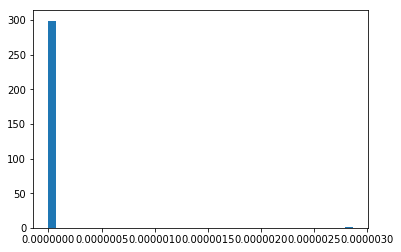

In [87]:
import matplotlib.pyplot as plt
eigs, eigvecs = np.linalg.eigh(gram)
print(np.min(eigs))
print(np.max(eigs))
plt.hist(eigs[:], 40)
plt.show()